In [1]:
import os
import logging
import numpy as np
import matplotlib.pyplot as plt
from ase.io import read, write
from ase import Atoms
from ase.units import _c
from ase import units as ase_units
import pandas as pd
from scipy.stats import pearsonr
from scipy.stats import wasserstein_distance


In [2]:
! pwd
! ls


/Users/bhatian1/Library/CloudStorage/OneDrive-AaltoUniversity/work_triton/MACE/Second_manuscript/Spectra_prediction/Benchmark_ML_spectra_out/Methanol_Casper
aims.xyz                    MACE_mu.txt
IR.jdx                      Spectra_benchmark_all.ipynb


### Here the experimental spectrum

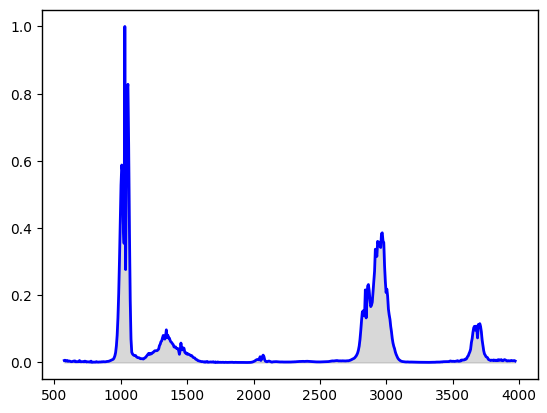

In [23]:
##  Reading the jdx IR file (Experimental spectra)
def read_jcamp(filename):
    x_data = []
    y_data = []
    data_started = False

    with open(filename, 'r') as file:
        for line in file:
            if line.startswith('##XYDATA'):
                data_started = True
                continue
            
            if line.startswith('##END='):
                break
            
            if data_started:
                x, *y_values = map(float, line.strip().split())
                x_data.append(x)
                y_data.append(sum(y_values))
    
    return np.array(x_data), np.array(y_data)

## To normalize the Intensity (optional)
def normalize_intensity(y_data):
    normalized_data = (y_data - min(y_data)) / (max(y_data) - min(y_data))
    return normalized_data

filename =  "IR.jdx"  ## Your file here
x_data, y_data = read_jcamp(filename)
normalized_y_data = normalize_intensity(y_data)


## For plotting the spectra
plt.plot(x_data, normalized_y_data,'-',c ='blue', label='Experiment', linewidth= 2)
# Fill the area under the extended curve
plt.fill_between(x_data, normalized_y_data, color='gray', alpha=0.3, label='Experiment')

# If the exp. data contains transmitance use the following code

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Function to read JCAMP-DX file
def read_jcamp(filename):
    x_data = []
    y_data = []
    data_started = False

    with open(filename, 'r') as file:
        for line in file:
            if line.startswith('##XYDATA'):
                data_started = True
                continue
            
            if line.startswith('##END='):
                break
            
            if data_started:
                x, *y_values = map(float, line.strip().split())
                x_data.append(x)
                y_data.append(sum(y_values))  # Assuming that y_values contains transmittance values
    
    return np.array(x_data), np.array(y_data)

# Function to convert transmittance to absorbance
def transmittance_to_absorbance(transmittance):
    return -np.log10(transmittance)

# Function to normalize data
def normalize_intensity(y_data):
    normalized_data = (y_data - min(y_data)) / (max(y_data) - min(y_data))
    return normalized_data

filename = "IR.jdx"  # Path to your file
x_data, y_data = read_jcamp(filename)

# Convert transmittance to absorbance
absorbance_data = transmittance_to_absorbance(y_data)

# Normalize absorbance
normalized_y_data = normalize_intensity(absorbance_data)

# Plot the spectra
plt.figure(figsize=(7, 5))
plt.plot(x_data, normalized_y_data, '-', c='blue', label='Experiment', linewidth=2)
plt.fill_between(x_data, normalized_y_data, color='gray', alpha=0.3, label='Experiment')
plt.xlabel('Wavenumber (cm$^{-1}$)')
plt.xlim(500,3600)
plt.ylabel('Normalized Absorbance')
plt.title('IR Spectrum')
plt.legend()
#plt.grid(True)
plt.show()


# Baseline correction, use if needed

In [ ]:
from scipy.interpolate import interp1d

# Provided data (ensure these are defined)
x = x_data
y_normalized = normalized_y_data  # Ensure y_data is normalized between 0 and 1

# Calculate the First Derivative
dy = np.gradient(y_normalized, x)

# Normalize the derivative (dy) between 0 and 1 using min-max normalization
dy_normalized = (dy - np.min(dy)) / (np.max(dy) - np.min(dy))

# Identify Peaks and Region of Interest Using Normalized Derivative Threshold
threshold = 0.0001  # Adjust this threshold as necessary
roi_mask = np.abs(dy) > threshold  # Mask for region of interest
#print("Region of Interest Mask:", roi_mask)

# Expand the Mask to Include Neighboring Data Points
expanded_mask = roi_mask.copy()
for i in range(1, 4):  # Expanding by three neighboring points in both directions
    expanded_mask[:-i] |= roi_mask[i:]
    expanded_mask[i:] |= roi_mask[:-i]

#print("Expanded Mask:", expanded_mask)

# Mask for baseline points (invert the expanded mask)
baseline_mask = ~expanded_mask
#print("Baseline Mask:", baseline_mask)
baseline_points_x = x[baseline_mask]
baseline_points_y = y_normalized[baseline_mask]

# Interpolate the Baseline
baseline_interpolator = interp1d(baseline_points_x, baseline_points_y, kind='linear', fill_value="extrapolate")
baseline = baseline_interpolator(x)

# Subtract the Baseline to Correct the Spectrum
corrected_y = y_normalized - baseline

# Plotting the results
fig, axs = plt.subplots(5, 1, figsize=(6, 6), sharex=True)

# (A) Original Spectrum
axs[0].plot(x, y_normalized, color='blue')
axs[0].set_title('A: Original Spectrum (Normalized)')
#axs[0].set_ylabel('Absorbance')
axs[0].set_xlim(500, 3700)


# (B) Normalized First Derivative
axs[1].plot(x, dy_normalized, color='orange')
axs[1].set_title('B: Normalized First Derivative')
#axs[1].set_ylabel('Normalized Derivative'
axs[1].set_xlim(500, 3700)

# (C) Region of Interest (Highlighted Points)
axs[2].plot(x, y_normalized, color='lightblue')
axs[2].scatter(x[baseline_mask], y_normalized[baseline_mask], color='magenta', label='Baseline points')
axs[2].legend()
axs[2].set_title('C: Baseline Points')
#axs[2].set_ylabel('Absorbance')
axs[2].set_xlim(500, 3700)


# (D) Interpolated Baseline
axs[3].plot(x, y_normalized, color='lightblue')
axs[3].plot(x, baseline, color='green', label='Interpolated baseline')
axs[3].legend()
axs[3].set_title('D: Interpolated Baseline')
#axs[3].set_ylabel('Absorbance')
axs[3].set_xlim(500, 3700)


# (E) Baseline-Corrected Spectrum
axs[4].plot(x, corrected_y, color='blue')
axs[4].set_title('E: Baseline-Corrected Spectrum')
axs[4].set_xlabel('Wave number (cm$^{-1}$)')
axs[4].set_ylabel('Absorbance')
axs[4].set_xlim(500, 3700)


# Adjust layout for better readability
plt.tight_layout()
plt.savefig("Baseline_corrected_exp_spectra.pdf", transparent=True)


# Auto-correlation function to compute the IR spectra from dipole moment

In [4]:
# auto-correlation code

__all__ = ["VibrationalSpectrum", "IRSpectrum"]


def cosine_sq_window(n_points: int):
    points = np.arange(n_points)
    window = np.cos(np.pi * points / (n_points - 1) / 2) ** 2
    return window


def fft_autocorrelation(data: np.array, n_lags: int):
    data = (data - np.mean(data)) / np.std(data)
    n_points = data.shape[0]
    fft_forward = np.fft.fft(data, n=2 * n_points)
    fft_autocorr = fft_forward * np.conjugate(fft_forward)
    fft_backward = np.fft.ifft(fft_autocorr)[:n_points] / n_points
    autocorrelation = np.real(fft_backward[: n_lags + 1])
    return autocorrelation

class VibrationalSpectrum:
    def __init__(self, data_file: str, resolution: int = 4096, window: callable = cosine_sq_window):
        self.data_file = data_file
        self.resolution = resolution
        self.window = window
        
        self.timestep = 0.5
        spectral_range = 0.5 / self.timestep / (_c / 1e13)
        spectral_resolution = spectral_range / (4 * resolution)
        logging.info(
            "Spectral resolutions: {:12.3f} [cm^-1]".format(spectral_resolution)
        )
        logging.info("Spectral range:       {:12.3f} [cm^-1]".format(spectral_range))

        self.res = spectral_resolution
        self.frequencies = []
        self.intensities = []

        
    def compute_spectrum(self, molecule_idx: int = 0):
        relevant_data = self._get_data(molecule_idx)
        autocorrelation = self._compute_autocorrelations(relevant_data)
        autocorrelation = self._process_autocorrelation(autocorrelation)

        self.frequencies = []
        self.intensities = []

        for autocorr in autocorrelation:
            frequencies, intensities = self._compute_spectrum(autocorr)
            self.frequencies.append(frequencies)
            self.intensities.append(intensities)

        self._process_spectrum()

    
        
    def _compute_spectrum(self, autocorrelation: np.array):
        """
        Compute the spectrum from the autocorrelation function.

        Args:
            autocorrelation (numpy.array): Autorcorrelation function.

        Returns:
            (numpy.array,numpy.array):
                frequencies:
                    Vibrational frequencies in inverse centimeters.
                intensities:
                    Intensities of the vibrational bands.
        """
        data = autocorrelation[: self.resolution]

        # Various tricks for nicer spectra
        # 1) Apply window function
        n_unpadded = data.shape[0]
        if self.window is not None:
            data *= self.window(n_unpadded)
        # 2) Zero padding
        data_padded = np.zeros(4 * n_unpadded)
        data_padded[:n_unpadded] = data
        # 3) Mirror around origin
        data_mirrored = np.hstack((np.flipud(data_padded), data_padded))
        # Compute the spectrum
        n_fourier = 8 * n_unpadded
        intensities = np.abs(
            self.timestep * np.fft.fft(data_mirrored, n=n_fourier)[: n_fourier // 2]
        )
        frequencies = np.arange(n_fourier // 2) / (n_fourier * self.timestep)
        # Conversion to inverse cm
        frequencies /= ase_units._c / 1e13
        return frequencies, intensities

    @staticmethod
    def _compute_autocorrelations(data: np.array):
        """
        Compute the autocorrelation function of the data. A separate autocorrelation is computred
        for every array dimension except the first axis.

        Args:
            data (numpy.array): Function array.

        Returns:
            numpy.array: Autocorrelation of the inputs.
        """
        n_data = data.shape[0]
        data_dim = data.shape[1:]
        n_lags = n_data - 2

        # Flatten data for easier iteration
        reshaped_data = data.reshape((n_data, -1))
        n_fields = reshaped_data.shape[1]

        # Compute all individual autocorrelations
        autocorrelations = np.zeros((n_fields, n_lags + 1))
        for field in range(n_fields):
            autocorrelations[field, ...] = fft_autocorrelation(
                reshaped_data[..., field], n_lags
            )

        # Reconstruct shape of original property
        autocorrelations = autocorrelations.reshape((*data_dim, -1))
        return autocorrelations
    
    def _get_data(self, molecule_idx: int):
        """
        Placeholder for extracting the required data from the HDF5 dataset.

        Args:
            molecule_idx (int): Index of the molecule for which the spectrum should be computed.
                                Uses the same conventions as schnetpack.md.System.
        """
        raise NotImplementedError

    def _process_autocorrelation(self, autocorrelation: np.array):
        """
        Placeholder for postprocessing the autocorrelation functions (e.g. weighting).

        Args:
            autocorrelation (numpy.array): Autorcorrelation function.
        """
        raise NotImplementedError

    def _process_spectrum(self):
        """
        Placeholder function if postprocessing should be applied to the spectrum (e.g. quantum coorections).
        """
        pass

    def get_spectrum(self):
        """
        Returns all computed spectra in the form of a list of tuples of frequencies and intensities.

        Returns:
            list: List of tuples of frequencies and intensities of all computed spectra.
        """
        spectrum = list(zip(self.frequencies, self.intensities))
        if len(spectrum) == 1:
            return spectrum[0]
        else:
            return spectrum


class IRSpectrum(VibrationalSpectrum):
    def __init__(self, data_file: str, resolution: int = 4096, dipole_moment_handle: str = "dipole"):
        super(IRSpectrum, self).__init__(data_file, resolution=resolution)
        self.dipole_moment_handle = dipole_moment_handle

    def _get_data(self, molecule_idx: int = None):
        file_extension = os.path.splitext(self.data_file)[-1]
        
        if file_extension in [".xyz", ".traj", ".pdb", ".in", ".out", ".extxyz"]:  # Add other ASE-supported extensions if needed
            # Read from ASE file
            atoms = read(self.data_file, index=":")
            
            # Initialize an array to store dipole moments for all molecules
            dipole_moments_array = []
        
            # Iterate through each molecule in the 'atoms' list
            for molecule in atoms:
                # Obtain the dipole moment for the current molecule
                dipole_moment = molecule.get_dipole_moment()
            
                # Append the dipole moment to the array
                dipole_moments_array.append(dipole_moment)
        
            # Convert the list of dipole moments to a NumPy array
            dipole_moments_array = np.array(dipole_moments_array)
        
        elif file_extension == ".txt":
            # Read from .txt file
            dipole_moments_array = np.array(np.loadtxt(self.data_file))
        
        else:
            raise ValueError("Unsupported file type: {}".format(file_extension))

        # Compute the time derivative using central differences if needed
        relevant_data = (dipole_moments_array[2:, ...] - dipole_moments_array[:-2, ...]) / (2 * self.timestep)
        
        return relevant_data

    def _process_autocorrelation(self, autocorrelation: np.array):
        dipole_autocorrelation = np.sum(autocorrelation, axis=0)
        return [dipole_autocorrelation]

# Spectra calculation

In [5]:
# To compute the spectra
def extract_spectra_function(data_file):
    # IR Spectrum
    ir_spectrum = IRSpectrum(data_file, resolution=1000)
    ir_spectrum.compute_spectrum()
    ir_spectrum_data = ir_spectrum.get_spectrum()
    print("IR Spectrum:", ir_spectrum_data)
    
    # Read the IR spectrum data
    ir_frequencies, ir_intensities = ir_spectrum_data
    # Filter frequencies greater than 499
    filtered_indices = ir_frequencies > 499
    IR_filtered_frequencies = ir_frequencies[filtered_indices]
    IR_filtered_intensities = ir_intensities[filtered_indices]
    
    # Normalize the filtered intensities between 0 and 1
    Normalized_ir_intensities = (IR_filtered_intensities - np.min(IR_filtered_intensities)) / (np.max(IR_filtered_intensities) - np.min(IR_filtered_intensities))

    return IR_filtered_frequencies, IR_filtered_intensities, Normalized_ir_intensities 

In [6]:
# DFT
DFT_Frequencies, DFT_Intensity, DFT_Normalized_Intensity = extract_spectra_function("aims.xyz")

# MACE
MACE_Frequencies, MACE_Intensity, MACE_Normalized_Intensity = extract_spectra_function("MACE_mu.txt")


IR Spectrum: (array([0.00000000e+00, 8.33910238e+00, 1.66782048e+01, ...,
       3.33313922e+04, 3.33397313e+04, 3.33480704e+04]), array([6.35948886e+01, 6.53031659e+01, 6.98763503e+01, ...,
       1.70234137e-05, 1.13546445e-05, 5.67957784e-06]))
IR Spectrum: (array([0.00000000e+00, 8.33910238e+00, 1.66782048e+01, ...,
       3.33313922e+04, 3.33397313e+04, 3.33480704e+04]), array([1.16612148e+01, 1.21174664e+01, 1.34408449e+01, ...,
       1.54101554e-05, 1.02755130e-05, 5.13857444e-06]))


# Spectra visualization

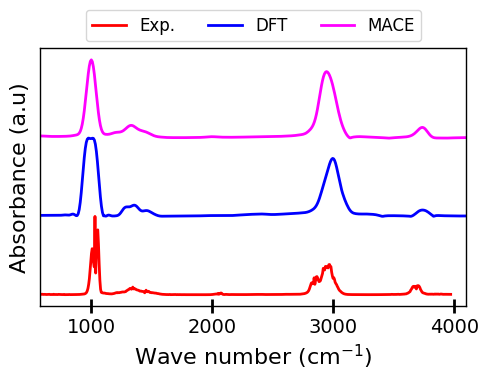

In [22]:
# Set up the figure
plt.figure(figsize=(5, 4))
plt.rcParams["axes.linewidth"] = 1

# Plot the experimental spectra
plt.plot(x_data, normalized_y_data, '-', c='red', label='Exp.', linewidth=2)

# Plot the baseline-corrected experimental spectra
#plt.plot(x_data, corrected_y, '--', c='red', label='Corr. Exp.', linewidth=2)

# Plot DFT spectrum
plt.plot(DFT_Frequencies, DFT_Normalized_Intensity + 1.0, '-', c='blue', label='DFT', linewidth=2)

# Plot MACE spectrum
plt.plot(MACE_Frequencies, MACE_Normalized_Intensity + 2.0, '-', c='magenta', label='MACE', linewidth=2)

# Plot formatting
plt.xlabel('Wave number (cm$^{-1}$)', fontsize=16)
plt.ylabel('Absorbance (a.u)', fontsize=16)
plt.legend(fontsize=12, loc='upper center', bbox_to_anchor=(0.5, 1.18), ncol=3)  # Adjust legend position
plt.xticks(range(0, 4010, 1000))
plt.xlim(580, 4100)
plt.tick_params(axis='x', which='both', direction='inout', length=10, width=2, labelsize=14, bottom=True, top=False)
plt.tick_params(axis='x', which='minor', direction='inout', length=5, labelsize=14, width=1)
plt.yticks([])
plt.tight_layout()

# Save the plot
plt.savefig("Comparison_all_spectra.pdf", transparent=True)

# Saving the DFT, ML spectral raw data to .txt files

In [8]:
# Create a dictionary with frequencies, intensities, and normalized intensities for each model
data_dict = {
    "DFT_Frequencies": DFT_Frequencies,
    "DFT_Intensities": DFT_Intensity,
    "Normalized_DFT_Intensities": DFT_Normalized_Intensity,
    "MACE_Frequencies": MACE_Frequencies,
    "MACE_Intensities": MACE_Intensity,
    "Normalized_MACE_Intensities": MACE_Normalized_Intensity
}

# Convert the dictionary to a pandas DataFrame
df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in data_dict.items()]))

# Save the DataFrame to a CSV file
df.to_csv("all_spectra_data.csv", index=False)

print("Data saved to all_spectra_data.csv")

Data saved to all_spectra_data.csv


# Matching spectra to experimental and DFT frequencies

In [9]:
# To match x-axis with the experimental values
def match_exp_spectra(base_frequency, frequency, intensity):
    # Interpolate intensities at the experimental wavenumbers
    matched_y_data = np.interp(base_frequency, frequency, intensity)
    # Normalize the interpolated intensities
    Normalized_matched_y_data = (matched_y_data - np.min(matched_y_data)) / (np.max(matched_y_data) - np.min(matched_y_data))
   
    return matched_y_data, Normalized_matched_y_data 

# Calculate the similarity coefiicients

# Use if baseline is not corrected

Results saved to correlations_and_distances.txt
Similarity Results:
Experimental vs DFT:
PCC: 0.7291, WD: 0.0546

Experimental vs ML models:
MACE: PCC = 0.7954, WD = 0.0554

DFT vs ML models:
MACE: PCC = 0.9162, WD = 0.0093


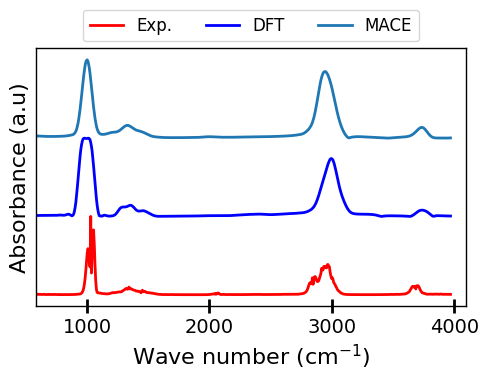

In [20]:
# Convert the experimental wavenumbers to a NumPy array (if not already)
matched_x_data_experiment = np.array(x_data)

# Align DFT and ML spectra with experimental x-axis
matched_dft_intensities, normalized_matched_dft_intensities = match_exp_spectra(x_data, DFT_Frequencies, DFT_Intensity)

# Initialize dictionaries for ML models
ml_models = {
    "MACE": (MACE_Frequencies, MACE_Intensity)
}

# Dictionaries to store matched intensities
matched_ml_intensities = {}
normalized_matched_ml_intensities = {}

# Match ML spectra to experimental x-axis
for model_name, (frequencies, intensities) in ml_models.items():
    matched_y, normalized_y = match_exp_spectra(x_data, frequencies, intensities)
    matched_ml_intensities[model_name] = matched_y
    normalized_matched_ml_intensities[model_name] = normalized_y

# Compute similarity coefficients
# 1. Experimental vs DFT
pearson_corr_exp_dft, _ = pearsonr(normalized_y_data, normalized_matched_dft_intensities)
wasserstein_dist_exp_dft = wasserstein_distance(normalized_y_data, normalized_matched_dft_intensities)

# 2. Experimental vs ML models
exp_ml_pcc = {}
exp_ml_wd = {}

# 3. DFT vs ML models
dft_ml_pcc = {}
dft_ml_wd = {}

for model_name, normalized_intensity in normalized_matched_ml_intensities.items():
    # Exp vs ML
    pcc_exp_ml, _ = pearsonr(normalized_y_data, normalized_intensity)
    wd_exp_ml = wasserstein_distance(normalized_y_data, normalized_intensity)
    exp_ml_pcc[model_name] = pcc_exp_ml
    exp_ml_wd[model_name] = wd_exp_ml

    # DFT vs ML
    pcc_dft_ml, _ = pearsonr(normalized_matched_dft_intensities, normalized_intensity)
    wd_dft_ml = wasserstein_distance(normalized_matched_dft_intensities, normalized_intensity)
    dft_ml_pcc[model_name] = pcc_dft_ml
    dft_ml_wd[model_name] = wd_dft_ml

    
# Save results to a text file
with open("correlations_and_distances.txt", "w") as f:
    f.write("Similarity Results:\n")
    f.write("Experimental vs DFT:\n")
    f.write(f"PCC: {pearson_corr_exp_dft:.4f}, WD: {wasserstein_dist_exp_dft:.4f}\n\n")
    f.write("Experimental vs ML models:\n")
    for model_name in exp_ml_pcc.keys():
        f.write(f"{model_name}: PCC = {exp_ml_pcc[model_name]:.4f}, WD = {exp_ml_wd[model_name]:.4f}\n")
    f.write("\nDFT vs ML models:\n")
    for model_name in dft_ml_pcc.keys():
        f.write(f"{model_name}: PCC = {dft_ml_pcc[model_name]:.4f}, WD = {dft_ml_wd[model_name]:.4f}\n")

print("Results saved to correlations_and_distances.txt")
! cat correlations_and_distances.txt

# Plotting matched spectra
plt.figure(figsize=(5, 4))
plt.rcParams["axes.linewidth"] = 1

# Plot experimental spectra
plt.plot(x_data, normalized_y_data, '-', c='red', label='Exp.', linewidth=2)

# Plot DFT spectra
plt.plot(x_data, normalized_matched_dft_intensities + 1.0, color="blue", label='DFT', linewidth=2)

# Plot ML spectra
offset = 2.0
for idx, (model_name, normalized_intensity) in enumerate(normalized_matched_ml_intensities.items()):
    plt.plot(
        x_data, 
        normalized_intensity + offset, 
        label=f'{model_name}', 
        linewidth=2
    )
    offset += 1.0  # Increment offset for each ML model

# Plot formatting
plt.xlabel('Wave number (cm$^{-1}$)', fontsize=16)
plt.ylabel('Absorbance (a.u)', fontsize=16)
plt.legend(fontsize=12, loc='upper center', bbox_to_anchor=(0.5, 1.18), ncol=3)  # Adjust legend position

# Adjust ticks and limits
plt.xticks(range(0, 4010, 1000))
plt.xlim(580, 4100)
plt.tick_params(axis='y', which='both', length=0, labelsize=0)
plt.tick_params(axis='x', which='both', direction='inout', length=10, width=2, labelsize=14, bottom=True, top=False)
plt.tick_params(axis='x', which='minor', direction='inout', length=5, width=1, labelsize=14)
plt.yticks([])

# Save the figure
plt.tight_layout()
plt.savefig("Matched_spectra.pdf", transparent=True)

# Use if baseline corrected exp data is used

In [ ]:
# Convert the experimental wavenumbers to a NumPy array (if not already)
matched_x_data_experiment = np.array(x_data)

# Align DFT and ML spectra with experimental x-axis
matched_dft_intensities, normalized_matched_dft_intensities = match_exp_spectra(x_data, DFT_Frequencies, DFT_Intensity)

# Initialize dictionaries for ML models
ml_models = {
    "MACE": (MACE_Frequencies, MACE_Intensity)
}

# Dictionaries to store matched intensities
matched_ml_intensities = {}
normalized_matched_ml_intensities = {}

# Match ML spectra to experimental x-axis
for model_name, (frequencies, intensities) in ml_models.items():
    matched_y, normalized_y = match_exp_spectra(x_data, frequencies, intensities)
    matched_ml_intensities[model_name] = matched_y
    normalized_matched_ml_intensities[model_name] = normalized_y

# Compute similarity coefficients
# 1. Experimental vs DFT
pearson_corr_exp_dft, _ = pearsonr(corrected_y, normalized_matched_dft_intensities)
wasserstein_dist_exp_dft = wasserstein_distance(corrected_y, normalized_matched_dft_intensities)

# 2. Experimental vs ML models
exp_ml_pcc = {}
exp_ml_wd = {}

# 3. DFT vs ML models
dft_ml_pcc = {}
dft_ml_wd = {}

for model_name, normalized_intensity in normalized_matched_ml_intensities.items():
    # Exp vs ML
    pcc_exp_ml, _ = pearsonr(corrected_y, normalized_intensity)
    wd_exp_ml = wasserstein_distance(corrected_y, normalized_intensity)
    exp_ml_pcc[model_name] = pcc_exp_ml
    exp_ml_wd[model_name] = wd_exp_ml

    # DFT vs ML
    pcc_dft_ml, _ = pearsonr(normalized_matched_dft_intensities, normalized_intensity)
    wd_dft_ml = wasserstein_distance(normalized_matched_dft_intensities, normalized_intensity)
    dft_ml_pcc[model_name] = pcc_dft_ml
    dft_ml_wd[model_name] = wd_dft_ml
    
    
# Save results to a text file
with open("correlations_and_distances.txt", "w") as f:
    f.write("Similarity Results:\n")
    f.write("Experimental vs DFT:\n")
    f.write(f"PCC: {pearson_corr_exp_dft:.4f}, WD: {wasserstein_dist_exp_dft:.4f}\n\n")
    f.write("Experimental vs ML models:\n")
    for model_name in exp_ml_pcc.keys():
        f.write(f"{model_name}: PCC = {exp_ml_pcc[model_name]:.4f}, WD = {exp_ml_wd[model_name]:.4f}\n")
    f.write("\nDFT vs ML models:\n")
    for model_name in dft_ml_pcc.keys():
        f.write(f"{model_name}: PCC = {dft_ml_pcc[model_name]:.4f}, WD = {dft_ml_wd[model_name]:.4f}\n")

print("Results saved to correlations_and_distances.txt")
! cat correlations_and_distances.txt

# Plotting matched spectra
plt.figure(figsize=(4, 6))
plt.rcParams["axes.linewidth"] = 1

# Plot experimental spectra
plt.plot(x_data, corrected_y, '-', c='red', label='Exp.', linewidth=2)

# Plot DFT spectra
plt.plot(x_data, normalized_matched_dft_intensities + 1.0, color="blue", label='DFT', linewidth=2)

# Plot ML spectra
offset = 2.0
for idx, (model_name, normalized_intensity) in enumerate(normalized_matched_ml_intensities.items()):
    plt.plot(
        x_data, 
        normalized_intensity + offset, 
        label=f'{model_name}', 
        linewidth=2
    )
    offset += 1.0  # Increment offset for each ML model

# Plot formatting
plt.xlabel('Wave number (cm$^{-1}$)', fontsize=10)
plt.ylabel('Absorbance (a.u)', fontsize=10)
plt.legend(fontsize=8, loc='upper center', bbox_to_anchor=(0.5, 1.18), ncol=2)  # Adjust legend position

# Adjust ticks and limits
plt.xticks(range(0, 4010, 1000))
plt.xlim(580, 4100)
plt.tick_params(axis='y', which='both', length=0, labelsize=0)
plt.tick_params(axis='x', which='both', direction='inout', length=10, width=2, bottom=True, top=False)
plt.tick_params(axis='x', which='minor', direction='inout', length=5, width=1)
plt.yticks([])

# Save the figure
plt.tight_layout()
plt.savefig("Matched_spectra.pdf", transparent=True)

# Comparison between AIMD and ML

In [ ]:
# Initialize dictionaries for ML models
ml_models = {
    "MACE": (MACE_Frequencies, MACE_Intensity)
}

# Match ML spectra to DFT (reference)
normalized_matched_ml_intensities = {}
for model_name, (ml_frequencies, ml_intensities) in ml_models.items():
    _, normalized_intensity = match_exp_spectra(DFT_Frequencies, ml_frequencies, ml_intensities)
    normalized_matched_ml_intensities[model_name] = normalized_intensity

# Calculate correlations and distances between DFT and ML
results = []
for model_name, normalized_intensity in normalized_matched_ml_intensities.items():
    # Compute PCC and WD for DFT vs ML
    pcc, _ = pearsonr(DFT_Normalized_Intensity, normalized_intensity)
    wd = wasserstein_distance(DFT_Normalized_Intensity, normalized_intensity)
    results.append((model_name, pcc, wd))

# Save results to a .txt file
with open("correlations_and_distances.txt", "w") as file:
    file.write("Comparison\tPCC\tEMD\n")
    for model_name, pcc, wd in results:
        file.write(f"DFT_and_{model_name}\t{pcc:.4f}\t{wd:.4f}\n")

print("Results saved to correlations_and_distances.txt")
! cat correlations_and_distances.txt

# Plotting
plt.figure(figsize=(4, 6))
plt.rcParams["axes.linewidth"] = 1

# Plot the DFT spectrum
plt.plot(DFT_Frequencies, DFT_Normalized_Intensity, color="blue", label='DFT', linewidth=2)

# Plot ML spectra
offset = 1.0
for model_name, normalized_intensity in normalized_matched_ml_intensities.items():
    plt.plot(DFT_Frequencies, normalized_intensity + offset, label=model_name, linewidth=2)
    offset += 1.0  # Increment offset for better visual separation

# Plot formatting
plt.xlabel('Wave number (cm$^{-1}$)', fontsize=10)
plt.ylabel('Absorbance (a.u)', fontsize=10)
plt.legend(fontsize=8, loc='upper center', bbox_to_anchor=(0.5, 1.18), ncol=2)  # Adjust legend position

# Adjust x-axis and y-axis ticks
plt.xticks(range(0, 4010, 1000))
plt.xlim(580, 4100)
plt.tick_params(axis='y', which='both', length=0, labelsize=0)
plt.tick_params(axis='x', which='both', direction='inout', length=10, width=2, bottom=True, top=False)
plt.tick_params(axis='x', which='minor', direction='inout', length=5, width=1)
plt.yticks([])

# Save the figure
plt.tight_layout()
plt.savefig("Matched_spectra.pdf", transparent=True)
